In [2]:
import networkx as nx
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
from src.helper import draw_spring, load_graph_from_json, score_normalize
np.random.seed(123)
#pd.set_option("display.precision", 3)
pd.options.display.float_format = '{:20,.3f}'.format


# 3 Network Centrality

As noted in Chapter 1, we can be interested in determining which nodes of a network are more important, more popular, or better connected. Network centrality measures aim to retrieve this information. 

There are a variety of network centrality measures, and although they overlap, they capture different ways in which a node may be regarded as central. Which centrality measure to use, depends on the research question one is interested in, on domain knowledge and sensitivity to context. 

The presentation that follows will present a range of centrality measures ranging from some very straightforward ones like degree centrality, to some more complex measures like Pagerank and HITS. The mathematics involved in this measures should be accessible to all readers (especially as ```numpy``` takes care of some otherwise intractable calculations).

It will also try to give you insight into some considerations that count when choosing which measure to focus on. This will involve comparing the results of different measures on simple networks. 

Please note that it is not possible to compare the results of different centrality measures unless they are "normalized" first. In fact, some measures are unintelligible without normalization. Normalization refers to making the measures insensitive to the number of nodes in a network and also putting the results in the same scale, for example from 0 to 1. For more on normalization please see Appendix 3. 



### 3.1 Degree and Degree Centrality

A first approach to finding which nodes are more central relies on degree. Degree is a property of nodes that records how many neighbors a node has. One would expect more central nodes to have a higher degree value than other nodes. It is possible to calculate Degree for every node and to subsequently rank the results from the one with most neighbors to the one with the least. This already provides with a simple, but reliable, centrality measure.
 
Degree provides for a discrete value. A node can have a degree score of 1, 5, 673, or any other value for that matter. Such a discrete value will not be directly useful because it is not contextualized to the total number of nodes in a network. For instance, a degree score of 5 in a network of 6 nodes is very different from a degree score of 5 in a network of 200.000 nodes. For this reason the degree centrality measure typically contextualizes the degree score by divides the degree score by the number of nodes in the network minus 1. A further form of normalization is often desirable, and makes the score range from 0 to 1. So in practice in this section we will be presenting these versions of the metric:

* Degree: The number of neighbors a node has.
* Degree centrality: The number of neighbors a node has contextualized by the total number of nodes in the network.
* Degree centrality normalized: The degree centrality score modified to range from o to 1.

Degree centrality can be further broken down into two versions: undirected and directed. The latter applies to directed networks (see Chapter 1) and allows one to consider only incoming edges or outgoing edges.

Degree centrality is the simplest of all the centrality scores, and it considers only the direct number of connections you have. It does not consider things like indirect connections, or the relative importance of those who connect to you. So for those we will have to look at other measures.


For an easy illustration of how the calculation of degree and centrality measures looks in practice, we turn to an example of a 1970s karate club. This network arises from a sociological study (Zachary 1977) of a karate club that would break up, with some students following the club's president and others the club instructor. What we are going to do here is to guess, using degree centrality, who might these two high profile club members be based on the number of friendships each karate club member has. For this, we can calculate the Degree scores for each individual node and subsequently rank the scores in a descending order. We suspect that the individuals with the highest Degree scores will be the instructor and the president.


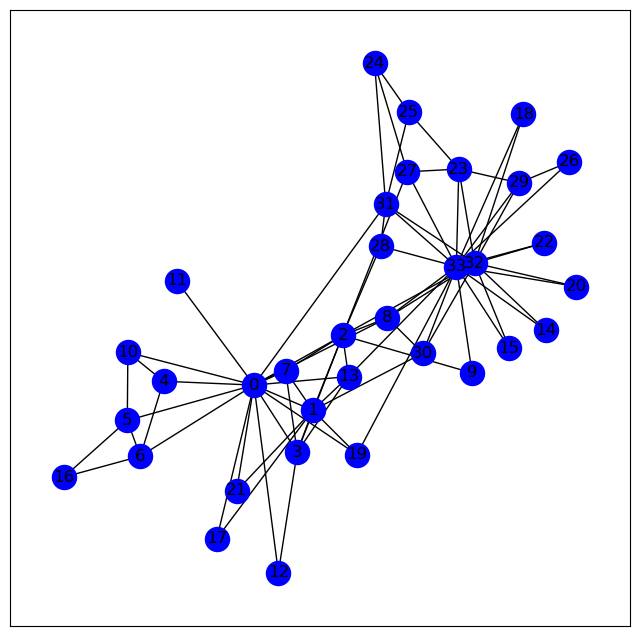

In [3]:
g_karate = nx.karate_club_graph()
draw_spring(g_karate)

In the table below we can see the degree scores raw (just the number of neighbors a node has) and the degree scores presented in proportion to the number of nodes in the network. You may see that the number on the "deg_normalized" column is more informative, and can be interpreted as a percentage.

In [10]:
g_karate = nx.karate_club_graph()
degree = nx.degree(g_karate)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degree_centrality = nx.degree_centrality(g_karate)
centscore = list(dict(degree_centrality).values())
centscore_norm = centscore/(np.sum(centscore))
resdf = pd.DataFrame({"node_id":nodeid, "degree":degscore, 
                      "deg_centrality":centscore, 
                      "deg_c_norm": centscore_norm})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality,deg_c_norm
node_id,,,
33,17,0.515,0.109
0,16,0.485,0.103
32,12,0.364,0.077
2,10,0.303,0.064
1,9,0.273,0.058
3,6,0.182,0.038
31,6,0.182,0.038
23,5,0.152,0.032
8,5,0.152,0.032


So the hypothesis is that the President and the instructor of the Karate Club would be the nodes with the highest degree or degree centrality scores. From our table these are nodes 33 and 0. This is in fact the case. The instructor is node 33 and the president is node 0. (In Zachary's original paper, the instructor is node 34 and the President node 1, but Python has the convention to start numbering at 0, and so the numbering changes in the ```networkx``` version of this network)

We can do a similar exercise for a simplified network of some train stations in the Netherlands shown below. 

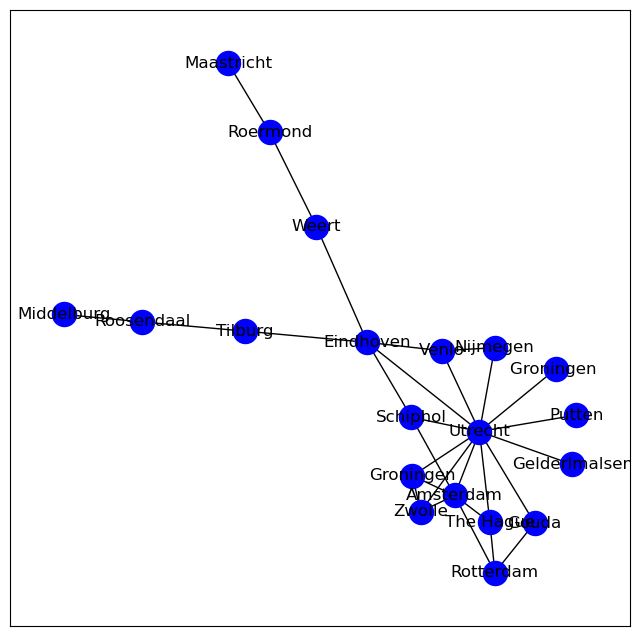

In [62]:
g_trains = load_graph_from_json("data/g_trains.json")
draw_spring(g_trains)

There are 20 train stations in this dataset. When we ask NetworkX to calculate the results, we can see that unsurprisingly, Utrecht has the highest degree (degree=12). *Utrecht Centraal* is widely known to be the largest train station in the Netherlands.

In [11]:
g_trains = load_graph_from_json("data/g_trains.json")
degree = nx.degree(g_trains)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
centrality = nx.degree_centrality(g_trains)
centscore = list(dict(centrality).values())
centscore_norm = centscore/(np.sum(centscore))
resdf = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality": centscore, 
                      "deg_c_norm": centscore_norm})
resdf.set_index("node_id", inplace=True)
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality,deg_c_norm
node_id,,,
Utrecht,12,0.632,0.207
Amsterdam,6,0.316,0.103
Eindhoven,5,0.263,0.086
Groningen,3,0.158,0.052
Zwolle,3,0.158,0.052
The Hague,3,0.158,0.052
Rotterdam,3,0.158,0.052
Schiphol,3,0.158,0.052
Venlo,3,0.158,0.052


Now lets enter into the nuts and bolts of this metric. Here we will introduce some simple mathematical notation (which we will see involves nothing more complicated than calculating averages) and make the distinction between undirected and directed versions of degree centrality.

#### A) Undirected degree centrality

Undirected degree centrality simply considers the degree score of each nodes and contextualized by the number of nodes the network has minus 1. In terms of notation, degree centrality can be represented by the following formula:

$$ \frac{degree(n)}{|N|-1} \mid n \in N $$

Here the large N refers to the set of all the nodes in the network. The small n refers to any particular node, whereas $ degree $ is a function that takes a node n, and returns how many edges link to that node. Here the $ \mid n \in N $ further specifies that n is a node belonging to the set of nodes in the network N. 

Remember the degree score is divided by the total number of nodes in the network in order to contextualize the score. Why 1 is substracted from this value might be puzzling. The subtraction is done to unbias the calculation by removing the node being considered from the total number of nodes. For all but the smallest networks this operation has very little practical difference, and some practical implementations of the algorithm will not bother to subtract 1.

The vertical bars in $ |N| $ refer to the cardinality of the nodes in the network. In set theory, cardinality is simply the number of items a set has. So the cardinality of the set of colors {blue, green, yellow} is 3. The cardinality of the set of days in the week is 7, etc. Mathematical notation, however, is contextual. The vertical bars around N are sometimes used to mean something else , so one must interpret them in the context of what is being discussed (sometimes, the formula might simply write "N", on the assumption that it is obvious that it refers to the number of nodes in the Network of which "n" is but one).

Since the calculation is very simple, it makes sense to try to apply the formula "by hand". Looking back at the trains network, we can see that Maastricht has a degree of 1: there is only one station that links to Maastricht, in this case Roermond. So the calculation is simply: 

$$ \frac{degree(Maastricht)}{|N|-1} $$

or 

$$ \frac{1}{20-1} = 0.053 $$

What is the degree of Eindhoven? It is connected to Tilburg, Venlo, Utrecht, Schipol, and Weert, so it has a degree of 5. This means that its centrality score should be:

$$ \frac{degree(Eindhoven)}{|N|-1} $$

or 

$$ \frac{5}{20-1} = 0.263 $$

You can check above, and see that this is the same result that networkx gives you.

#### B) Directed (in-degree and out-degree) centrality

In directed networks, one can differentiate between in-degree (the number of nodes that have an edge pointing to a given node) and out-degree (the number of nodes that a given node points out To). 

In our case law network of consumer protection cases, we might expect that the number of incoming reference to a case is a good indicator of precedent value. These would be highly cited cases. Alternatively, cases that have a high out-degree score will be cases that are rich in citations and which can be a good starting point for lawyers trying to get familiar with case law on consumer protection.

The consumer protection cases network has 1.614 nodes, so it cannot be presented here in full. We will only present now the top 20 cases for in-coming citations.

In [52]:
g_consprot = load_graph_from_json("data/g_consprot.json")
indegree = g_consprot.in_degree(g_consprot)
outdegree = g_consprot.out_degree(g_consprot)
nodeid = list(dict(indegree).keys())
indegscore = list(dict(indegree).values())
outdegscore = list(dict(outdegree).values())

incentrality = nx.in_degree_centrality(g_consprot)
incentscore = list(dict(incentrality).values())
outcentrality = nx.out_degree_centrality(g_consprot)
outcentscore = list(dict(outcentrality).values())

incentscore_norm = incentscore/np.sum(incentscore)
outcentscore_norm = outcentscore/np.sum(outcentscore)

resdf = pd.DataFrame({"node_id":nodeid, 
                      "indegree":indegscore,
                      "outdegree": outdegscore,
                      "indeg_centrality": incentscore,
                      "outdeg_centrality": outcentscore,
                      "incent_norm": incentscore_norm,
                      "outdeg_norm": outcentscore_norm})
resdf.set_index("node_id", inplace=True)
resdf.to_csv("data/consprot_results.csv")
resdf.sort_values('indegree', ascending=False).head(20)


,indegree,outdegree,indeg_centrality,outdeg_centrality,incent_norm,outdeg_norm
node_id,,,,,,
61992CJ0091,46,7,0.029,0.004,0.017,0.003
62003CJ0210,41,31,0.025,0.019,0.015,0.012
62001CJ0491,40,40,0.025,0.025,0.015,0.015
61994CJ0178,31,5,0.019,0.003,0.012,0.002
62008CJ0040,30,16,0.019,0.010,0.011,0.006
62010CJ0618,29,18,0.018,0.011,0.011,0.007
62003CJ0402,25,9,0.015,0.006,0.009,0.003
61984CJ0178,24,8,0.015,0.005,0.009,0.003
61989CJ0241,23,6,0.014,0.004,0.009,0.002


The winner here is case 61992CJ0091 with 46 incoming citations. 

Now lets do the same for out degree.

In [53]:
resdf = pd.read_csv("data/consprot_results.csv")
resdf.sort_values('outdegree', ascending=False).head(20)


,node_id,indegree,outdegree,indeg_centrality,outdeg_centrality,incent_norm,outdeg_norm
177,62001CJ0491,40,40,0.025,0.025,0.015,0.015
220,62003CJ0210,41,31,0.025,0.019,0.015,0.012
507,62006CJ0244,9,27,0.006,0.017,0.003,0.010
174,62012CJ0470,15,24,0.009,0.015,0.006,0.009
678,62014CJ0377,2,22,0.001,0.014,0.001,0.008
42,62007CJ0343,4,22,0.002,0.014,0.002,0.008
468,62002CJ0434,14,21,0.009,0.013,0.005,0.008
223,62009CJ0324,12,21,0.007,0.013,0.005,0.008
702,62015CJ0168,1,19,0.001,0.012,0.000,0.007
171,62010CJ0618,29,18,0.018,0.011,0.011,0.007


Here the winner is case 62001CJ0491, which is also a highly cited case (with 40 incoming citations).

We can once more check manually what is going on. For this, we take the  in-degree and divide it by the number of nodes in the network. For example:

$$ \frac{indegree(62003CJ0210)}{|N|-1} $$

or 

$$ \frac{41}{1614-1} = 0.025 $$

GIving us the same result as seen above

### 3.2 Closeness Centrality

Degree, in-degree, and out-degree (centrality) consider the direct neighbors of a node, but not indirect neighbors. For instance, if A is connected to B and B is connected to C, the indirect relationship between A and C -through B- is not taken into consideration in the degree based measures we have explored. 

Depending on the task at hand, this can be an important oversight. For example if we want to make a model of corporations that are linked through supply chains, we should not be interested only in direct suppliers, but in suppliers that are downstream or upstream from the company under study. 

Closeness centrality is a measure that takes such indirect relationships into consideration. While it is a bit more complicated than degree centrality, it is also very easy to understand and to calculate. The only difficulty here is is that it relies on shortest path information, and getting the shortest path between two nodes can be a non-trivial problem. From a user perspective this is not a significant issue, as ```networkx``` will readily provide this info. However finding shortest paths in a very complex networks might be computationally expensive.

Closeness centrality expresses the average closeness between a target node $ u $ and the set of all other nodes it can reach $ V $, when taking the shortest path between the node under examination and the reachable nodes (this shortest path is often called the 'geodesic path'). The greater the average closeness of one node to all other nodes using the shortest paths, the more central the node is. Remember here that closeness is the reciprocal of the distance thus 

$$ closeness = \frac{1}{distance} $$

 The details on this algorithm are provided below.

The importance of closeness centrality becomes most evident when we have nodes that have a "tail" behind them. They have one direct neighbor, but many indirect neighbors standing in line behind them. This is literally what we see when do the analysis for the kite graph, with the tail of the kite being constituted by nodes 7, 8 and 9. Lets first recall the structure of this graph:



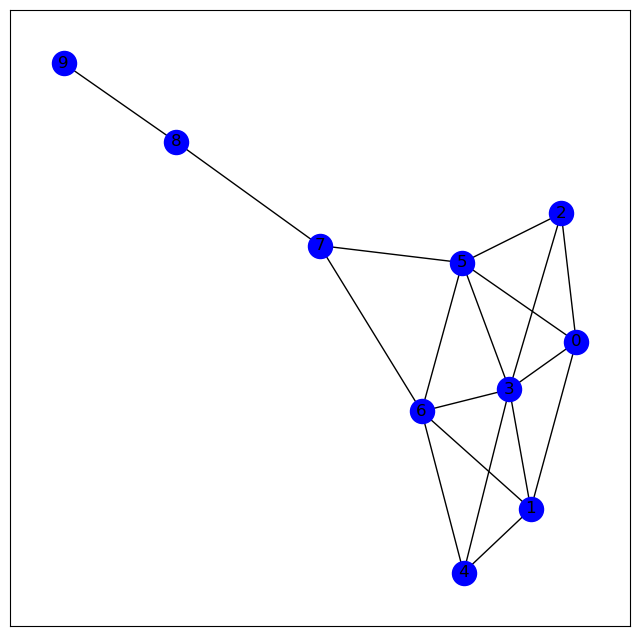

In [91]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

In terms of degree, node 3 is the clear winner in the first position. Node 7 is far behind on the 8th position.


In [63]:
g_kite = nx.krackhardt_kite_graph()
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
degcent_norm = degcentscore/(np.sum(degcentscore))
resdf = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                      "deg_c_norm":degcent_norm})
resdf.set_index("node_id", inplace=True)
resdf.to_csv("data/kite_closeness_results_1.csv")
resdf.sort_values('degree', ascending=False)

,degree,deg_centrality,deg_c_norm
node_id,,,
3,6,0.667,0.167
5,5,0.556,0.139
6,5,0.556,0.139
0,4,0.444,0.111
1,4,0.444,0.111
2,3,0.333,0.083
4,3,0.333,0.083
7,3,0.333,0.083
8,2,0.222,0.056


However one might think that node 7 is undervalued. It has only 3 direct neighbors, but it actually has many indirect neighbors, including nodes 8 and 9, that can only be reached by passing through 7. Lets see how 7 does when use this second form of centrality score.

Things change quite a bit if we look at closeness centrality. Now node 7 moves up from being in the 8th position to being tied for 3rd! 


In [64]:

resdf = pd.read_csv("data/kite_closeness_results_1.csv")

closenesscent = nx.closeness_centrality(g_kite)
closescores = list(closenesscent.values())
closescore_norm = closescores/(np.sum(closescores))
resdf["closeness_score"] = closescores
resdf["closeness_norm"] = closescore_norm
resdf.to_csv("data/kite_closeness_results_2.csv")

resdf.sort_values('closeness_norm', ascending=False)

,node_id,degree,deg_centrality,deg_c_norm,closeness_score,closeness_norm
5,5,5,0.556,0.139,0.643,0.122
6,6,5,0.556,0.139,0.643,0.122
3,3,6,0.667,0.167,0.600,0.114
7,7,3,0.333,0.083,0.600,0.114
0,0,4,0.444,0.111,0.529,0.100
1,1,4,0.444,0.111,0.529,0.100
2,2,3,0.333,0.083,0.500,0.095
4,4,3,0.333,0.083,0.500,0.095
8,8,2,0.222,0.056,0.429,0.081
9,9,1,0.111,0.028,0.310,0.059



In fact other scores also change.  Node 3 is no longer the winner. Under closeness node 3 is penalized for having long paths for nodes 8 and 9. Nodes 5 and 6 obtain better scores. They have less nodes directly linking to them, but they are closer to the other nodes, which is what is relevant for closeness centrality.

One might intuitively say that node 7 is still underperforming in relation of its real importance. If we cut out node 7, the network becomes disconnected. This is not so if you cut any node from 0 to 6. This will come back when we consider betweenness centrality.

So which one is better? Degree centrality or closeness? What is crucial to note for now is how different they are. Domain knowledge is needed to see which one matters most. Here we can compare the outputs of these two measures directly. 


<Axes: ylabel='closeness_norm'>

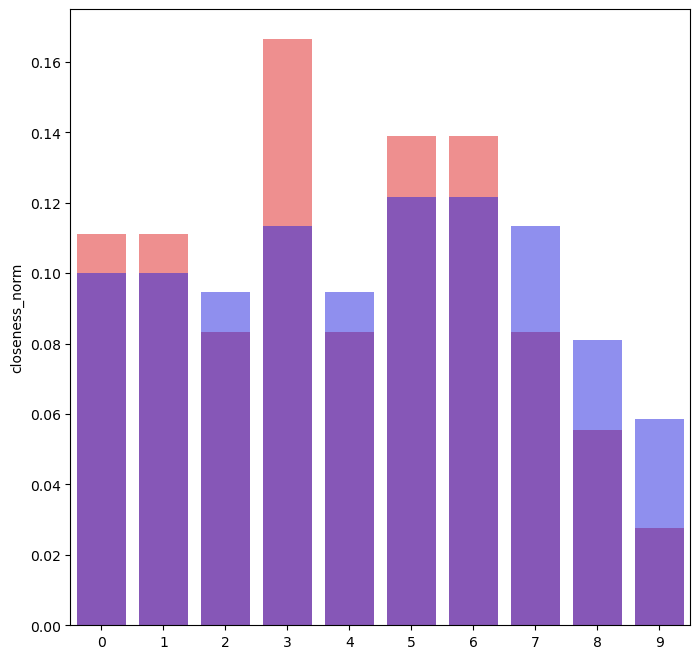

In [65]:

resdf = pd.read_csv("data/kite_closeness_results_2.csv")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
sns.barplot(x = resdf.index, y = resdf.deg_c_norm, alpha=0.5, ax=ax, color="red")
sns.barplot(x = resdf.index, y= resdf.closeness_norm, alpha=0.5, ax=ax, color="blue")


Now lets try to unpack the algorithm in more detail.


The only real difficulty in closeness centrality is getting the shortest paths. While this is a non-trivial and computationally expensive task, from the user persepctive, the ```networkx``` library can calculate shortest paths for us. Here we get the number of steps from node 8 to every other node.

In [19]:
g_kite = nx.krackhardt_kite_graph()
nx.single_source_shortest_path_length(g_kite, source = 8)

{8: 0, 7: 1, 9: 1, 5: 2, 6: 2, 0: 3, 2: 3, 3: 3, 1: 3, 4: 3}

Or if you just want to see the itinerary, and not the number of steps:

In [20]:
g_kite = nx.krackhardt_kite_graph()
nx.shortest_path(g_kite, source = 8, target= 6 )

[8, 7, 6]

If you have the itinerary, you can use ```len``` to get the number of steps. Because the itinerary counts the origin node, you should subtract 1 from the result.

Now having the shortest path score, let's move to calculate closeness centrality. The formula here is:

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath(v,u)} $$

Compared to degree centrality, this formula can appear intimidating at first sight, but it is in fact very straightforward.

In this formula, the number of nodes $ v $ that can reach a certain specific node $ u $ minus 1 is expressed by $ |V|-1 $. This top part of the formula is nothing that we have not encountered before.

The bottom part of the formula represents the sum of the shortest path lengths between each of those nodes $ v $ and $ u $. Here the notation can be a bit tricky so it is worth explaining it step by step.

By $spath(v,u)$ we understand a function that gives us the shortest path between a target node $u$ and every node $v$ that can reach u. In this context, it is customary to denote sets with capital letters, and elements of that set with the same letter uncapitalized, so $v$ represents every node in $V$.

The $\Sigma$ represents a sum in the so-called Sigma notation. The $ \Sigma $ means 'sum', the subscript denotes the element where the sum begins, and the superscript the element where it ends. So in order to express a sum through the sequence a, b, c and d, we can just write: $ \sum_{a}^{d} $ 

So in our case, the $\sum_{V_1}^{V_n}spath(v,u)$ represents the sum of all those shortest paths for every node $v$, starting from the first element of the set V, node $v_1$, to the last element of the set V referred to as $v_n$.
. 


#### A) Closeness with weights (distances)

We previously explained that edges can have weights and that networks can be fully connected. A network of document similarity scores will tipically have both of these features: similarity scores provide the weight, and every document is compared to every other document, resulting in a fully connected network. 

What would be the expected result of running the closeness centrality algorithm on this network without specifying any weight information? The result would be that all nodes are equally, and maximally, close to each other, all getting a closeness centrality score of 1. We can see this in the example below:

In [21]:
g_docs = load_graph_from_json("data/g_docs.json")
res = nx.closeness_centrality(g_docs)
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {v}")

for node 8 closeness score is 1.0
for node 7 closeness score is 1.0
for node 6 closeness score is 1.0
for node 5 closeness score is 1.0
for node 4 closeness score is 1.0
for node 3 closeness score is 1.0
for node 2 closeness score is 1.0
for node 1 closeness score is 1.0
for node 0 closeness score is 1.0


To avoid this uninformative result, it is possible to adjust the closeness to consider the weights, with the weights indicating document similarity (the higher the weight, the more similar the document).

Adding weight information does not require us to change the formula in any substantial way. The only thing that changes is that the function returning the shortest path now considers not only discrete steps, but weighted steps, which we may signal by adding the $ w $ subscript to the formula: 

$$ \frac{|V|-1}{\sum_{V_1}^{V_n}spath_w(v,u)} $$

Weighted shortest paths were discussed in Chapter 2, section E.

Redeploying our measure, now with weights, provides more informative results that we can see below:



In [25]:
res = nx.closeness_centrality(g_docs, distance='weight')
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,3)}")

for node 8 closeness score is 2.799
for node 1 closeness score is 2.724
for node 2 closeness score is 2.702
for node 7 closeness score is 2.566
for node 3 closeness score is 2.515
for node 0 closeness score is 2.503
for node 5 closeness score is 1.978
for node 6 closeness score is 1.866
for node 4 closeness score is 1.233


It is good to know that closeness centrality takes into consideration how well-connected a node is (the numerator of the formula increases when more nodes can reach the node of interest). Consider the following example, where nodes D and E have a single very short path between them. This path is very short, but it is penalized by the very small numerator, as D and E can only be reached by one other node.

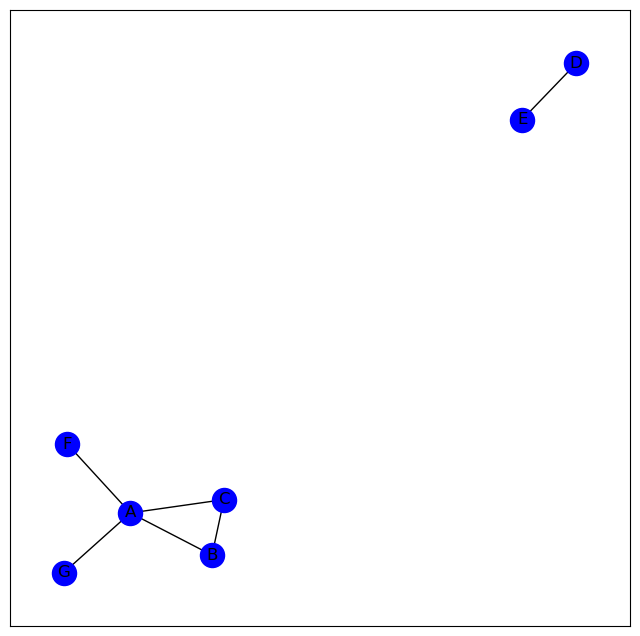

In [26]:
g_disconnected2 = nx.Graph()
g_disconnected2.add_nodes_from(['A','B','C','D','E','F','G'])
g_disconnected2.add_edges_from([('A','B'),('B','C'), ('C','A'), ('A','F'),('A','G'),('D','E')])
draw_spring(g_disconnected2)

In [27]:
res = nx.closeness_centrality(g_disconnected2, distance='weight')
res_view = [ (v,k) for k,v in res.items() ]
res_view.sort(reverse=True)
for v,k in res_view:
    print(f"for node {k} closeness score is {np.round(v,3)}")

for node A closeness score is 0.667
for node C closeness score is 0.444
for node B closeness score is 0.444
for node G closeness score is 0.381
for node F closeness score is 0.381
for node E closeness score is 0.167
for node D closeness score is 0.167


## 3.3 Eigenvector Centrality

Another approach to determine the centrality of a node is to consider how likely it is to reach that node if one would randomly 'walk' through the network. If a node would be reached more frequently than other nodes, this could signal that the node is more central and consequently more relevant. 

Eigenvector centrality can be understood on the basis of this 'random walker' idea. It simulates a random walker moving from node to node, each time with equal probability of going to the adjacent node. The idea is that if the walk goes on for very long, the probability of seeing the walker at a particular node will stabilize, giving you the Eigenvector Centrality value. 

To illustrate, we calculate the Eigenvector Centrality scores for the train stations network giving you both the un-normalized and normalized scores. Drawing from the "random walker" interpretation of the Eigenvector Centrality metric, the normalized scores (those that have been squeezed to range from 0 to 1) can be interpreted as probabilities.

In [30]:
g_trains = load_graph_from_json("data/g_trains.json")
eigcentrality = nx.eigenvector_centrality(g_trains)
nodeid = list(eigcentrality.keys())
eigcentrality_scores = list(eigcentrality.values())
eig_norm = eigcentrality_scores / (np.sum(eigcentrality_scores))
resdf = pd.DataFrame({"station":nodeid, 
                      "score":eigcentrality_scores,
                      "score_norm": eig_norm})
resdf.set_index("station")
resdf.sort_values('score', ascending=False)

,station,score,score_norm
1,Utrecht,0.569,0.162
0,Amsterdam,0.390,0.111
9,Groningen,0.267,0.076
15,Zwolle,0.267,0.076
19,Schiphol,0.264,0.075
4,Eindhoven,0.254,0.073
14,The Hague,0.247,0.070
6,Venlo,0.217,0.062
13,Rotterdam,0.174,0.050
7,Nijmegen,0.171,0.049


Recall that degree centrality favors the number of direct neighbors one has, closeness centrality takes into account indirect networks, including thus nodes that are in a "tail" formation behind a node. 

Eigenvector centrality takes into consideration the probabilities that one may move from one appear in one node, and this is a function of how well connected that node is, and also of how well connected the nodes around it are. By virtue of this, one added value of eigenvector centrality is that it takes into consideration the relative importance of nodes. In other words: A node gets a high eigenvector centrality score if it is linked to other nodes which also have a high eigenvector centrality score. Intuitively, consider that "famous" may be defined (at least partly) in terms of having many friends who are also "famous". 

Lets go back to the kite and remember that:
* Degree centrality prefers node 3, and puts node 7 far on the back.
* Closeness prefer both 5 and 6, and puts node 7 in 4th place
Now we will see that
* Eigenvector centrality also prefers node 3, and also puts node 7 far on the back.

Note why this might be so. Node 3 not only has high degree, but it is also close to nodes 5, 6, 0 and 1, which also have high degree. By contrast node 7 is "friends" with 5 and 6, but also with the unpopular 8, so it cannot rank as high.



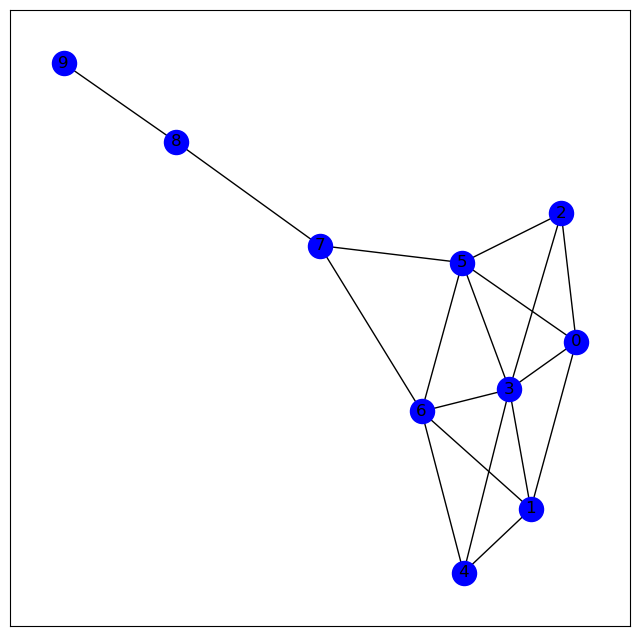

In [31]:
g_kite = nx.krackhardt_kite_graph()
draw_spring(g_kite)

We can see the scores here. 

In [66]:
g_kite = nx.krackhardt_kite_graph()
degree = nx.degree(g_kite)
nodeid = list(dict(degree).keys())
degscore = list(dict(degree).values())
degcentrality = nx.degree_centrality(g_kite)
degcentscore = list(dict(degcentrality).values())
degcent_norm = degcentscore/(np.sum(degcentscore))
closenesscent = nx.closeness_centrality(g_kite)
closescores = list(closenesscent.values())
closescore_norm = closescores/(np.sum(closescores))
eigcentrality = nx.eigenvector_centrality(g_kite)
eigscore = list(dict(eigcentrality).values())
eig_norm = eigscore/np.sum(eigscore)

resdf = pd.DataFrame({"node_id":nodeid, 
                      "degree":degscore, 
                      "deg_centrality":degcentscore,
                      "deg_c_norm": degcent_norm,
                        "closeness_cent": closescores,
                        "closeness_norm": closescore_norm,
                        "eig_centrality": eigscore,
                        "eig_norm": eig_norm})
resdf.set_index("node_id", inplace=True)
resdf.to_csv("data/kite_eig_results_1.csv")
resdf.sort_values('eig_centrality', ascending=False)

,degree,deg_centrality,deg_c_norm,closeness_cent,closeness_norm,eig_centrality,eig_norm
node_id,,,,,,,
3,6,0.667,0.167,0.600,0.114,0.481,0.171
5,5,0.556,0.139,0.643,0.122,0.398,0.142
6,5,0.556,0.139,0.643,0.122,0.398,0.142
0,4,0.444,0.111,0.529,0.100,0.352,0.125
1,4,0.444,0.111,0.529,0.100,0.352,0.125
2,3,0.333,0.083,0.500,0.095,0.286,0.102
4,3,0.333,0.083,0.500,0.095,0.286,0.102
7,3,0.333,0.083,0.600,0.114,0.196,0.070
8,2,0.222,0.056,0.429,0.081,0.048,0.017


Notice how the unnormalized scores are not really comparable, but the normalized scores are. Node 3 in the kite is pretty much always central, so the scores should be roughly teh same. But because unnormalized scores do not have a common metric, they reflect some misleading variation and have a meaningless metric on the y axis (which has therefore been removed in the plot below). Using only the normalized scores provides a clearer picture.

Text(0.5, 1.0, 'only normalized')

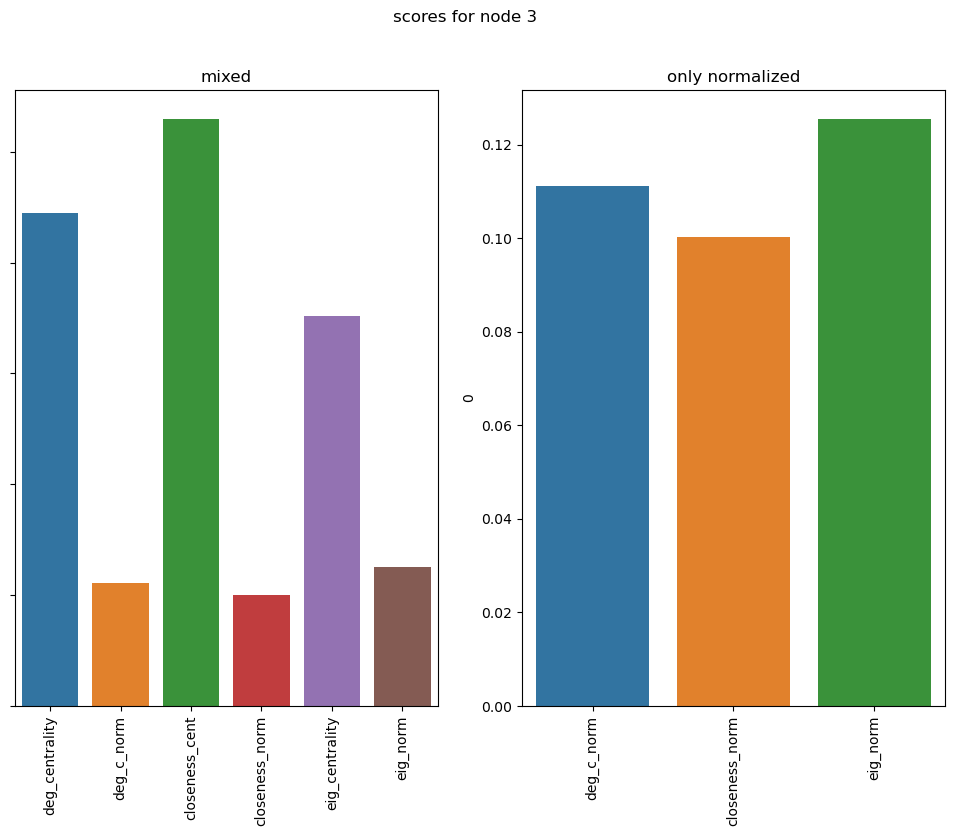

In [70]:

resdf = pd.read_csv("data/kite_eig_results_1.csv", index_col="node_id")

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))
plt.suptitle("scores for node 3")
sns.barplot(x = resdf.drop("degree", axis=1).columns, y= resdf.drop("degree", axis=1).loc[0,:], ax = ax[0]).set(yticklabels=[], ylabel=None)
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("mixed")

sns.barplot(x = resdf.drop(["degree","deg_centrality", "closeness_cent", "eig_centrality"], axis=1).columns, 
            y= resdf.drop(["degree","deg_centrality", "closeness_cent", "eig_centrality"], axis=1).loc[0,:], ax = ax[1])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("only normalized")



An advantage of eigenvector centrality (and measures similar to it computationally like pagerank or HITS) is that it relies on matrix multiplications instead of shortest path calculations. Because modern computers are highly optimized to perform matrix multiplications, eigenvector centrality (and similar measures) may perform better in large networks than simpler measures like closeness or betweeness.



The mathematics of Eigenvector Centrality are complicated, in particular for non-technical persons. We are not going to present it in full, but we will, in the next example, sketch an idea of how Eigenvector Centrality works and some ways of arriving at it. 

In its simplest form, Eigenvector Centrality is what you get by repeatedly multiplying: 

* an **adjacency matrix** by 
* a **vector of probabilities** associated with each node.

Let us use a small network to illustrate. Imagine we have four nodes "a", "b", "c" and "d", and we are making a network of their linkages. We begin representing this network as a $ 4 \times 4 $ adjacency matrix $A$ (it is customary to represent matrices with capital letters). In this matrix a 1 indicates there is a connection between a node in the rows and another in the columns, and a 0 means that there is no connection. If one picks node "a" in the rows, we see that it connects to "b" and "d" in the columns. If we read the row of node "b", we see that it connects with "a" and "d" in the columns. And so on. 

$$ A = \begin{pmatrix}
0 & 1 & 1 & 0 \\ 
1 & 0 & 1 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
\end{pmatrix} $$

For the vector of probabilities "v", to begin with, we can just assume that one is equally likely to be in each of the four nodes of the matrix (as we repeatedly multiply $A$ and $v$ the values of $v$ will change).

$$ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $$

The basic idea is that if one multiplies "A" and "v" one will "apply" the structure of the adjacency matrix to the vector, or "scale" the vector by the matrix. In every such multiplication, we will have a transition or "walk" from the equal probability starting point $ v = \begin{pmatrix}{0.25,0.25,0.25,0.25}\end{pmatrix} $ to some other state. If one does this multiple times, updating the value of "v" in every iteration, it is possible that the values will "converge" or stabilize, which means they will not change much from multiplication to multiplication. The now stable values of v, represent the probability that the random walker will be in a particular row of the matrix (or node of the network) after an indeterminate number of walks. 

In mathematical notation this repeated updating by matrix - vector multiplication may be expressed in this manner (note that $ := $ here emphasizes that we are assigning a value, and not asserting an equality).

$$ v_{i+1}:= Av_{i} $$

This is done for values of $ i = {1, 2, 3, 4, ...} $ until it is the case that the values of $ v $ do not change from multiplication to multiplication. We may express this as an approximate equality because one may be satisfied with very small variations in the score of v, instead of requiring it to be be exactly the same.

$$ v_{i+1} \approx v_{i} $$

Once we are satisfied with the result the vector should be "normalized" by dividing it by its norm. This is done because what interests us is the relative magnitude associated with each node, and not absolute values, which can be very large due to the repeated multiplication (There may be technical reasons to normalize after each iteration of the multiplication, instead of just at the end, this may avoid numbers becoming too large and difficult to calculate).

$$ \frac{v}{||v||} $$

Why is this called Eigenvector Centrality? Because a property of the adjacency matrix, namely, the Eigenvector associated with its highest Eigenvalue, will give the same results as the method presented above. But before showing this, lets put procedure in practice. We first create the adjacency matrix of the kite graph.

In [35]:
g_kite = nx.krackhardt_kite_graph()
A = nx.adjacency_matrix(g_kite)
A.todense()

array([[0, 1, 1, 1, 0, 1, 0, 0, 0, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [1, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 0, 1, 0, 0, 1, 0, 0, 0],
       [1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])

The next step is to have an initial vector of probabilities. Each element of this vector should be 1/10 or 0.1. Remember that probabilities have to sum to 1, and if it is equally probable that one may be in each of the 10 nodes of the kite graph, then we have a 0.1 probability for each.

In [36]:
v = (np.ones(10)/10)
v

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

Finally we repeatedly multiply the adjacency matrix by the vector of probabilities and normalize the results. We will just do it 100 times. In more complicated scenarios, more repetitions might be required to do the trick. Note that in ```numpy``` the operator ```@``` is used to express matrix multiplication.

After the multiplications are done, we normalize the results by dividing the results vector by its norm.

Here we can see how this "by-hand" approach matches with the ```networkx``` built-in function

In [71]:
g_kite = nx.krackhardt_kite_graph()
A = nx.adjacency_matrix(g_kite)
v = (np.ones(10)/10)

for i in range(0,100):
    v = A@v
vnorm = np.linalg.norm(v)
vresult = v / vnorm

resdf = pd.read_csv("data/kite_eig_results_1.csv", index_col="node_id")
resdf['vresult'] = vresult
resdf.to_csv("data/kite_eig_results_2.csv")
resdf


,degree,deg_centrality,deg_c_norm,closeness_cent,closeness_norm,eig_centrality,eig_norm,vresult
node_id,,,,,,,,
0,4,0.444,0.111,0.529,0.100,0.352,0.125,0.352
1,4,0.444,0.111,0.529,0.100,0.352,0.125,0.352
2,3,0.333,0.083,0.500,0.095,0.286,0.102,0.286
3,6,0.667,0.167,0.600,0.114,0.481,0.171,0.481
4,3,0.333,0.083,0.500,0.095,0.286,0.102,0.286
5,5,0.556,0.139,0.643,0.122,0.398,0.142,0.398
6,5,0.556,0.139,0.643,0.122,0.398,0.142,0.398
7,3,0.333,0.083,0.600,0.114,0.196,0.070,0.196
8,2,0.222,0.056,0.429,0.081,0.048,0.017,0.048


Finally let us approach it from the perspective of eigenvalues and eigenvectors. 

Eigenvalues and eigenvectors are a property of certain matrices, which often very difficult to get by hand, but which ```numpy``` can provide on command.

Eigenvectors are just vectors, that when multiplied by the matrix ($ matrix \times vector $), scale, but do not change direction. 

Every eigenvector will have an eigenvalue -a value, that is, just a number- associated with it, which records how much the vector is scaled. Here we are interested in the eigenvector that is associated with the largest eigenvalue.

The largest eigenvalue here is 4.3. This is in index position 0 of the numpy array (arrays like a python list, start from zero). 

In [49]:
g_kite = nx.krackhardt_kite_graph()
A = nx.adjacency_matrix(g_kite)
vals, vecs = np.linalg.eig(A.todense())
vals

array([ 4.30640379,  1.60639741,  1.41421356,  0.64036468, -0.40434195,
       -0.816375  , -2.        , -1.41421356, -1.46406328, -1.86838565])

For all but the smallest networks it can be difficult to visually inspect which value is the largest, here we can use ```numpy.argmax``` to return the position of this value.

In [50]:
g_kite = nx.krackhardt_kite_graph()
A = nx.adjacency_matrix(g_kite)
vals, vecs = np.linalg.eig(A.todense())
np.argmax(vals)

0

So if we want the eigenvector associated with the largest eigenvalue, what we are looking for is the vector at position 0.


In [51]:
g_kite = nx.krackhardt_kite_graph()
A = nx.adjacency_matrix(g_kite)
vals, vecs = np.linalg.eig(A.todense())
vecs[:,0]

array([0.3522094 , 0.3522094 , 0.28583499, 0.48102086, 0.28583499,
       0.39769064, 0.39769064, 0.19586058, 0.04807349, 0.01116326])

Note what is going on here code wise. ```vecs``` gives us all the eigenvectors. 
Each of the eigenvectors (associated with every eigenvalue) is in a column. Using ```vecs[:,0]``` tell us "give me all the rows, under column zero. And that is exactly the same as the repeat multiplication method or the built in ```nx.eigenvector_centrality``` function.

In [72]:
resdf = pd.read_csv("data/kite_eig_results_2.csv", index_col="node_id")
resdf['eigen_approach'] = vecs[:,0]
resdf

,degree,deg_centrality,deg_c_norm,closeness_cent,closeness_norm,eig_centrality,eig_norm,vresult,eigen_approach
node_id,,,,,,,,,
0,4,0.444,0.111,0.529,0.100,0.352,0.125,0.352,0.352
1,4,0.444,0.111,0.529,0.100,0.352,0.125,0.352,0.352
2,3,0.333,0.083,0.500,0.095,0.286,0.102,0.286,0.286
3,6,0.667,0.167,0.600,0.114,0.481,0.171,0.481,0.481
4,3,0.333,0.083,0.500,0.095,0.286,0.102,0.286,0.286
5,5,0.556,0.139,0.643,0.122,0.398,0.142,0.398,0.398
6,5,0.556,0.139,0.643,0.122,0.398,0.142,0.398,0.398
7,3,0.333,0.083,0.600,0.114,0.196,0.070,0.196,0.196
8,2,0.222,0.056,0.429,0.081,0.048,0.017,0.048,0.048


## 3.4 PageRank

PageRank is a variant of the Eigenvector centrality which is applicable to directed networks. Like Eigenvector Centrality it considers not only the ammount of links one receives, but also the popularity of those linking to us. It is also based on the "random walk idea": the pagerank score corresponds to the likelihood of a user ending up on that page by randomly clicking from link to link. PageRank used to form the basis for the Google search engine algorithm. Here we can see how it might work in a simplified citation network of the American case Obergefell v. Hodges.

(note that here we are using an image instead of the code used to generate it. Currently the package used to generate this image is not being maintained).

<img src="images/ch3/obergefell.png"/>


In [11]:
g_ob = load_graph_from_json("data/obergefell.json")
pagerank = nx.pagerank(g_ob, alpha=0.75)
nodeid = list(pagerank.keys())
pagerankscores = list(pagerank.values())
resdf = pd.DataFrame({"nodes":nodeid, "pagerank":pagerankscores})
resdf.to_csv("data/pagerank_results_1.csv", index=None)
resdf.sort_values("pagerank", ascending=False)

,nodes,pagerank
12,Loving_v_Virginia,0.151
10,NAACP_v_State_of_Alabama,0.104
8,Griswold_v_Connecticut,0.082
7,Roe_v_Wade,0.063
9,Lochner_v_New_York,0.058
11,Union_Pacific_Railroad_v_Botsford,0.058
6,PPvCasey,0.054
14,County_of_Sacramento_vs._Lewis,0.054
15,Romer_v_Evans,0.054
1,Lawrence_v_Texas,0.046


One key difference with Eigenvector Centrality is that PageRank incorporates a "teleportation" factor that is controlled with the ```alpha``` parameter seen above: As a random walker moves through the network, it may get stuck on a node or nodes that has only incoming links to it, and no outgoing links. For example, Loving v. Virginia or Lochner v. New York. The teleportation factors implies a random chance of teleporting anywhere else in the network and thus avoids the random walk getting stuck in such dead ends. Absent the teleportation factor, end nodes (nodes with only incoming links) will tend to absorb all the network flow and give us an uninformative result.

Above we have defined ```alpha``` to equal 75, but the usual value is 85. This implies a $1-alpha$ chance of teleportation, so in this case, a 0.25 chance of teleportation...


Now lets enter into the technical details: 

The first thing PageRank needs, is to transform the adjacency matrix into a transition matrix. While an adjacency matrix will record a 1 if there is a connection between a node in the rows and a node in the column, the transition matrix will record the probability of jumping from a node in the rows to another one in the columns in such a way that the probabilities all sum to 1. 

Imagine once more we have four nodes A, B, C, D, that are connected as follows:

$$ A = \begin{pmatrix}
0 & 1 & 0 & 1 \\ 
1 & 0 & 0 & 1 \\ 
1 & 1 & 0 & 1 \\ 
0 & 1 & 1 & 0 \\ 
\end{pmatrix} $$

If we are in node A (first row), we can jump to node B or D. If we are in node B (second row) we can jump to node A and D. Granting equal probability of making that jump, we now weight the connection in terms of probabilities as in this manner:

$$ T = \begin{pmatrix}
0 & 0.5 & 0 & 0.5 \\ 
0.5 & 0 & 0 & 0.5 \\ 
\frac{1}{3} & \frac{1}{3} & 0 & \frac{1}{3} \\ 
0 & 0.5 & 0.5 & 0 \\ 
\end{pmatrix} $$

Note that each row will sum to 1 as per the rules of probability.

Just like with Eigenvector centrality, the next thing needed is a vector that reflects the probability of being in each of the nodes of the network. There are four nodes, so a vector with equal probability will be a vector of 0.25s.

$$ v = \begin{pmatrix}
0.25 & 0.25 & 0.25 & 0.25 \\ 
\end{pmatrix}$$

In principle what needs to be done next is to multiply the vector of probabilities by the transpose of the transition matrix many times. 

$$ v_{i+1}:= T^Tv_{i} $$

However, if this algorithm is used, nodes that are sinks (have no outgoing links) or which form a closed circuit can trap all the pagerank scores. So something needs to be changed. What happens is that the transition matrix G is modified by adding a teleportation factor alpha to it, so that for every node there is a 1-alpha chance of getting out.

In NetworkX the transition matrix so modified is called the google matrix, it is for this reason that we have chosen to denote this with the letter G.

$$ G = T * alpha + [(1-alpha)/n]_{nxn} $$

Now we can go ahead and repeatedly multiply G and the vector of probabilities many times to get the results we need.

$$ v_{i+1}:= G^Tv_{i} $$

Just like with Eigenvector Centrality, eventually the values of $v$ will not change much from multiplication to multiplication, leading us to our score.

Pagerank is presented as a percentage, so then we normalize this value by dividing it for its sum:

$$ pagerank = \frac{v}{\sum v} $$


This is how we can get the scores using a for loop.

In [13]:

G = nx.google_matrix(g_ob, alpha=0.75).T
v = np.ones(16)/16

for i in range(0, 1000):
    v = G @ v.reshape(16,-1)
    vnorm = np.linalg.norm(v)
    v = v/vnorm

vresult = np.ravel(v/sum(v))
vresult    

resdf = pd.read_csv("data/pagerank_results_1.csv")
resdf['unofficial'] = vresult
resdf.to_csv("data/pagerank_results_2.csv", index=None)
resdf.sort_values("unofficial")

,nodes,pagerank,unofficial
0,Obergefell_v_Hodges,0.042,0.042
1,Lawrence_v_Texas,0.046,0.046
2,Bowers_v_Hardwick,0.046,0.046
3,Zablocki_v_Redhail,0.046,0.046
4,Turner_v_Safley,0.046,0.046
5,Windsor_v_United_States,0.046,0.046
13,Baker_v_Nelson,0.046,0.046
6,PPvCasey,0.054,0.054
14,County_of_Sacramento_vs._Lewis,0.054,0.054
15,Romer_v_Evans,0.054,0.054


And as expected, the eigenvalues associated with the largest eigenvector give us the same result.

In [14]:
A = nx.google_matrix(g_ob, alpha=0.75).T
vals, vecs = np.linalg.eig(A)
argmax = np.argmax(vals)
eigresult = np.ravel(vecs[:,argmax])
eigresult = eigresult/np.sum(eigresult)


resdf = pd.read_csv("data/pagerank_results_2.csv")
resdf['eigen_result'] = np.around(eigresult,3)
resdf

,nodes,pagerank,unofficial,eigen_result
0,Obergefell_v_Hodges,0.042,0.042,0.042+0.000j
1,Lawrence_v_Texas,0.046,0.046,0.046+0.000j
2,Bowers_v_Hardwick,0.046,0.046,0.046+0.000j
3,Zablocki_v_Redhail,0.046,0.046,0.046+0.000j
4,Turner_v_Safley,0.046,0.046,0.046+0.000j
5,Windsor_v_United_States,0.046,0.046,0.046+0.000j
6,PPvCasey,0.054,0.054,0.054+0.000j
7,Roe_v_Wade,0.063,0.063,0.063+0.000j
8,Griswold_v_Connecticut,0.082,0.082,0.082+0.000j
9,Lochner_v_New_York,0.058,0.058,0.058+0.000j


## 3.5 Betweenness Centrality

So far we have been thinking of centrality in relation to the number of neighbors a node has. 

1. Degree centrality simply focuses on the number of direct neighbors a node has.
2. Closeness centrality takes into account not just direct neighbors, but also indirectly linked nodes.
3. Eigenvector centrality and Pagerank consider the connectedness or "fame" of the neighbors.

Now we will introduce a different focus. We will consider as most important not just nodes that have a lot of neighbors, but nodes that are "mediators", or "brokers" in the network. These are nodes that hold the network together. If they are deleted, this will cause severe disruption in the network, possibly disconnecting parts of the network. Betweenness centrality considers this broker status. To illustrate how betweenness centrality can be determined or explained, we start with the example of actual political brokerage. The "Florentine Families" graph is a study of marriage alliances between families in Renaissance Florence by Breiger and Pattison (1986). The graph of such network of marriage alliances can be seen below:



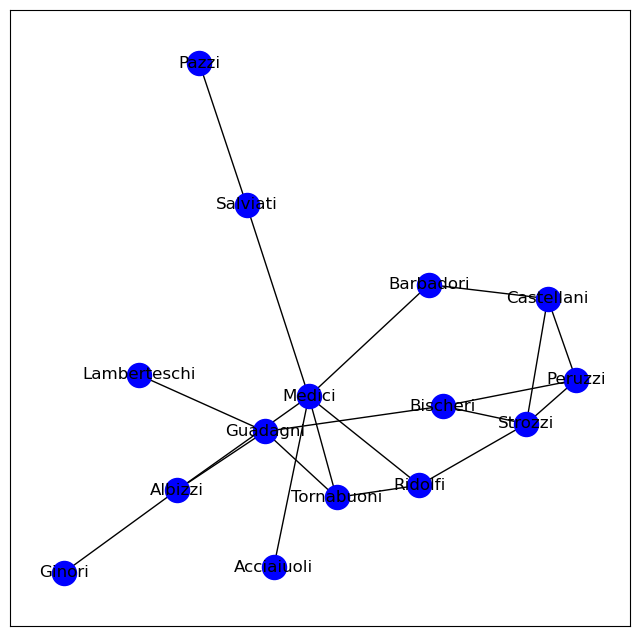

In [205]:
g_florentine = nx.florentine_families_graph()
draw_spring(g_florentine)

The Medici were the dominant family of this time period. However, although conventional centrality measures will show that the Medici have a strong political situation, they do not really signal dominance. The closeness score for Medici is 0.09, but Strozzi, Barbadori, Ridolfi, Tornabuouni, Albizzi and Guadagni are not far behind. 

Once we factor in betweenness, the scores for the aforementioned families drop significantly and we get far better impression of the dominance of the Medici.

In [17]:
g_florentine = nx.florentine_families_graph()
families = list(g_florentine.nodes)
closeness = nx.closeness_centrality(g_florentine)
closeness_scores = list(closeness.values())
closeness_norm = closeness_scores/np.sum(closeness_scores)

betweenness = nx.betweenness_centrality(g_florentine)
betweenness_scores = list(betweenness.values())
betweenness_norm = betweenness_scores/(np.sum(betweenness_scores))


resdf = pd.DataFrame({'families': families, 
                        'closeness_norm': closeness_norm,
                      'betweenness_norm': betweenness_norm})
resdf.set_index("families", inplace=True)
resdf.to_csv("data/betweeeness_florentine_results.csv")
resdf

,closeness_norm,betweenness_norm
families,,
Acciaiuoli,0.059,0.000
Medici,0.090,0.304
Castellani,0.062,0.032
Peruzzi,0.059,0.013
Strozzi,0.070,0.060
Barbadori,0.070,0.054
Ridolfi,0.080,0.066
Tornabuoni,0.078,0.053
Albizzi,0.078,0.124


Here we can see the massive contrast. The blue bars highlight the closeness centrality, and the red bars betweenness centrality. (If a red bar exceeds a blue bar, this indicates the extent to which the closeness centrality score is higher than the betweenness centrality score.)

<Axes: xlabel='betweenness_norm', ylabel='families'>

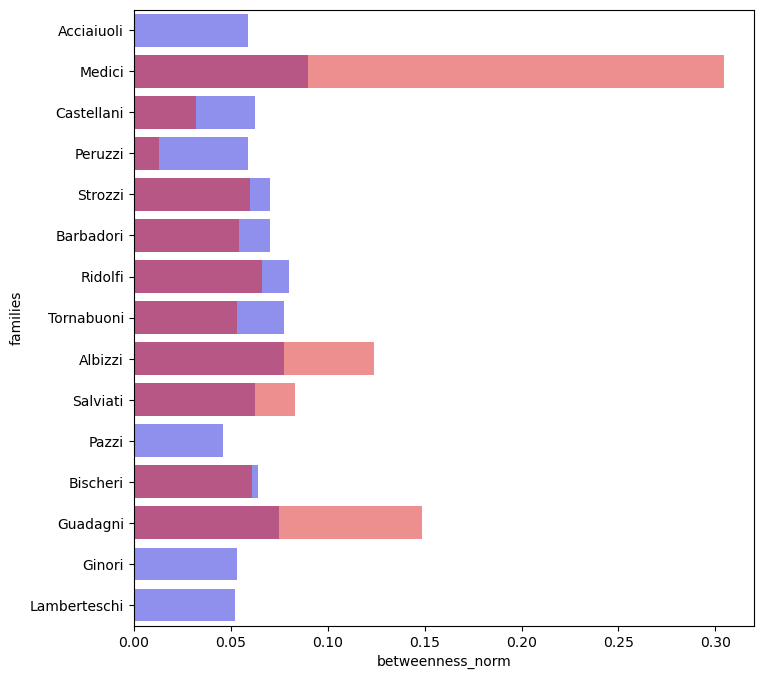

In [21]:
resdf = pd.read_csv("data/betweeeness_florentine_results.csv", index_col="families")
plt.figure(figsize=(8,8))
sns.barplot(y = resdf.index, x = resdf.closeness_norm, color='blue', alpha =0.5)
sns.barplot(y = resdf.index, x = resdf.betweenness_norm, color='red', alpha = 0.5)

Finally, let's see what happens when we remove the Medici family from the graph. As we can see, the graph suddenly becomes disconnected.

In [29]:
g_florentine.nodes

NodeView(('Acciaiuoli', 'Medici', 'Castellani', 'Peruzzi', 'Strozzi', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi'))

{'Acciaiuoli': Text(0.3279532519996992, -0.9410366986802753, 'Acciaiuoli'),
 'Castellani': Text(-0.16280525010506608, 0.38510157752124097, 'Castellani'),
 'Peruzzi': Text(-0.0018290622306341897, 0.36105496714570623, 'Peruzzi'),
 'Strozzi': Text(-0.03791108661876944, 0.2573057297584493, 'Strozzi'),
 'Barbadori': Text(-0.32996576011650486, 0.4309725024345771, 'Barbadori'),
 'Ridolfi': Text(-0.013124010609825243, 0.08717928763802192, 'Ridolfi'),
 'Tornabuoni': Text(0.13123512120825268, 0.007495719410270427, 'Tornabuoni'),
 'Albizzi': Text(0.5115388650131837, 0.012917657625599037, 'Albizzi'),
 'Salviati': Text(-1.0, -0.39737265602147087, 'Salviati'),
 'Pazzi': Text(-0.8701473128054235, -0.3375129127518975, 'Pazzi'),
 'Bischeri': Text(0.13159312241340268, 0.22575846309973785, 'Bischeri'),
 'Guadagni': Text(0.29474889678538196, 0.04658693494175433, 'Guadagni'),
 'Ginori': Text(0.6783370939362625, -0.020909107424833474, 'Ginori'),
 'Lamberteschi': Text(0.34037613113004095, -0.1175414646968804

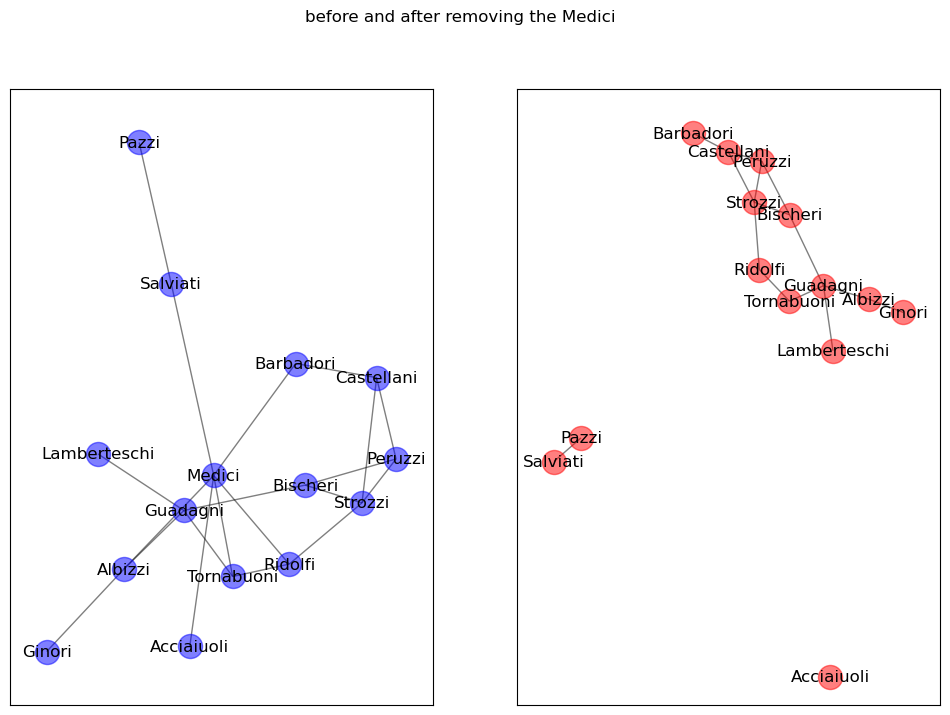

In [35]:
g_florentine = nx.florentine_families_graph()
g_subflorentine = g_florentine.subgraph([x for x in g_florentine.nodes if not x=="Medici"])

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,8))

plt.suptitle("before and after removing the Medici")

pos = nx.spring_layout(g_florentine, seed =123)
nx.draw_networkx_nodes(g_florentine, pos=pos, node_color="blue", node_size=300, alpha=0.5, ax=ax[0])
nx.draw_networkx_edges(g_florentine, pos=pos, edge_color="black", alpha=0.5, ax=ax[0]);
nx.draw_networkx_labels(g_florentine, pos = pos, ax = ax[0])

pos = nx.spring_layout(g_subflorentine, seed =123)
nx.draw_networkx_nodes(g_subflorentine, pos=pos, node_color="red", node_size=300, alpha=0.5, ax=ax[1])
nx.draw_networkx_edges(g_subflorentine, pos=pos, edge_color="black", alpha=0.5, ax=ax[1]);
nx.draw_networkx_labels(g_subflorentine, pos = pos, ax = ax[1])



Betweeness centrality is not always a relevant measure. The notion of a broker makes the  most sense when some entities cannot be reached directly, there is a cost involved or impossibility of reaching some entity directly and thus a mediator is needed. Case citations networks do not make heavy use of brokers, because any case can cite any other case without much effort. Even if the judge found a case reading another case, he is not obliged to cite the "broker" that gave this information. Lets now go back to our network of consumer protection cases, and lets get the top 100 betweeness centrality scores for this network.

Lets get the top 100 betweeness centrality scores for this network.

In [26]:
g_consprot = load_graph_from_json("data/g_consprot.json")
betweenness = nx.betweenness_centrality(g_consprot)
cases = list(betweenness.keys())
scores = list(betweenness.values())
scores_norm = scores / (np.sum(scores))

resdf = pd.DataFrame({'cases':nx.closeness_centrality(g_consprot).keys(), 
                      'betweenness': scores,
                      "betweenesss_norm": scores_norm})

resdf.set_index("cases", inplace=True)
resdf = resdf.sort_values("betweenness", ascending=False).head(100)
resdf.to_csv("data/betweeness_consprot_results.csv")
resdf


,betweenness,betweenesss_norm
cases,,
62003CJ0210,0.004,0.052
62001CJ0491,0.004,0.048
62010CJ0618,0.003,0.044
61994CJ0178,0.002,0.027
62011CJ0092,0.002,0.024
...,...,...
61993CJ0017,0.000,0.003
61981CJ0261,0.000,0.002
62015CJ0168,0.000,0.002


Even after removing 100 brokers, the network structure looks roughly the same.

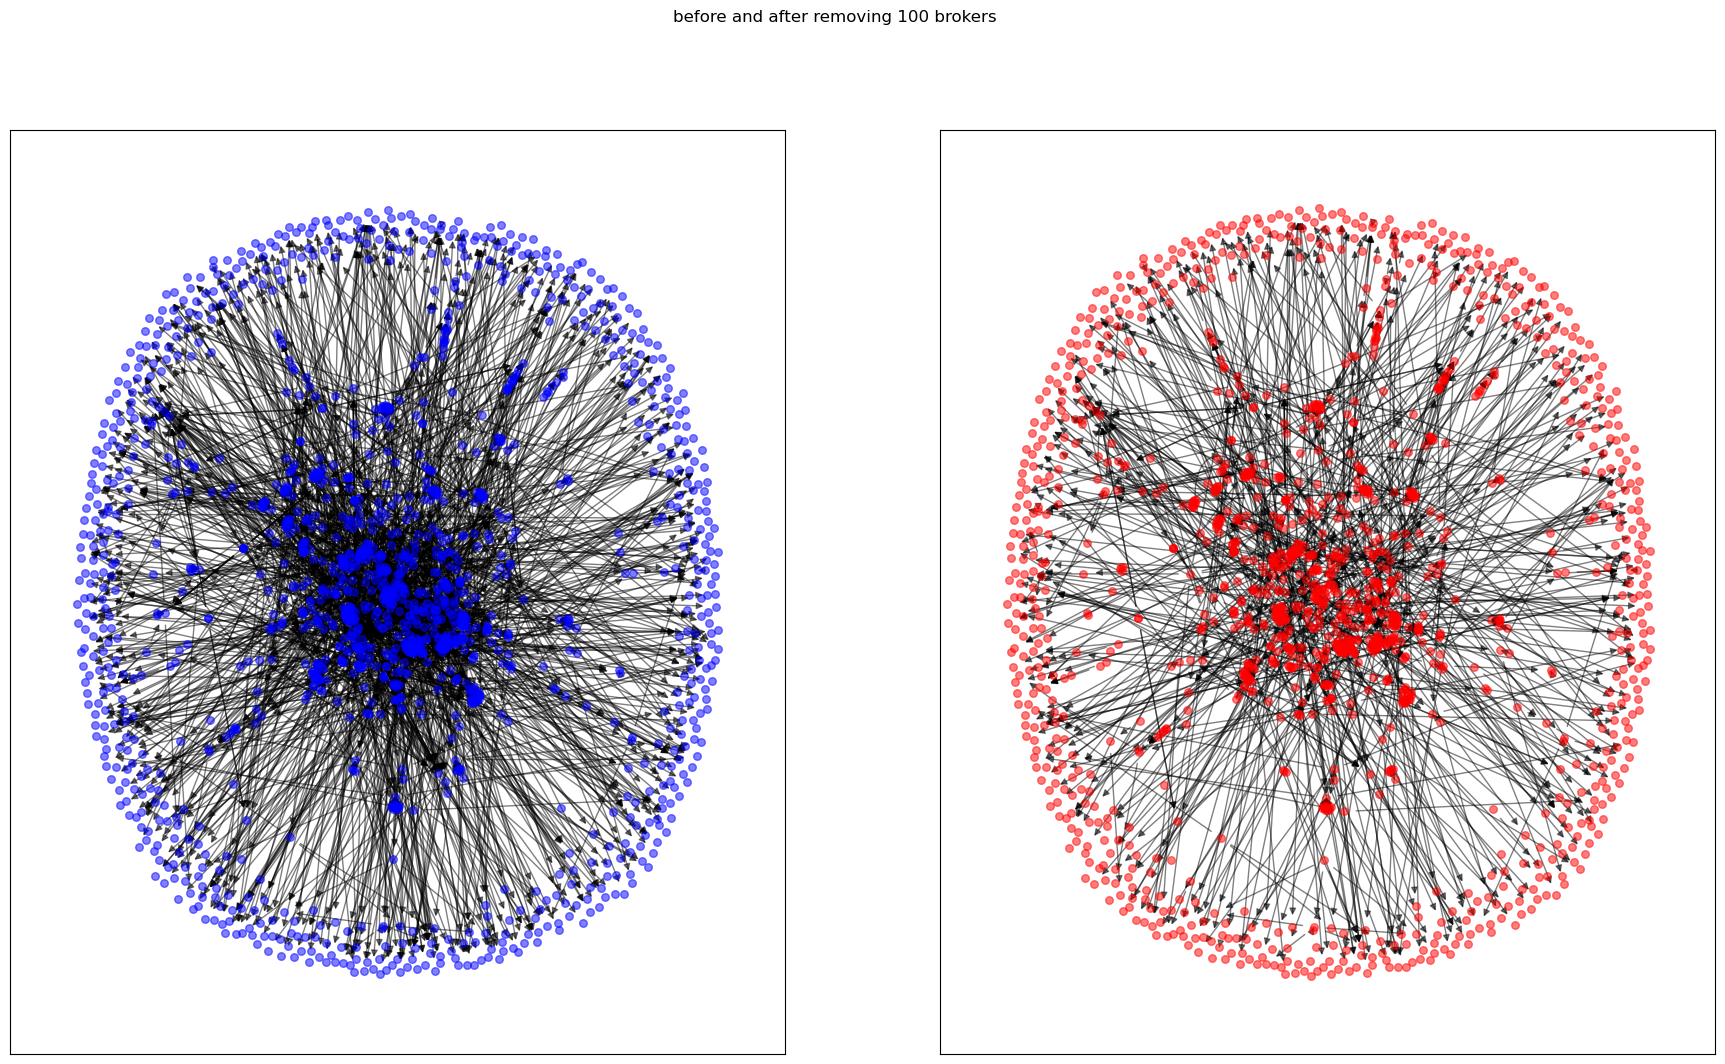

In [27]:
resdf = pd.read_csv("data/betweeness_consprot_results.csv", index_col="cases")
nodelist = resdf.index
removededges = [(x,y) for x,y in g_consprot.edges if (x not in nodelist and y not in nodelist)]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,12))

plt.suptitle("before and after removing 100 brokers")

pos = nx.spring_layout(g_consprot, seed =123)
nx.draw_networkx_nodes(g_consprot, pos=pos, node_color="blue", node_size=30, alpha=0.5, ax=ax[0])
nx.draw_networkx_edges(g_consprot, pos=pos, edge_color="black", alpha=0.5, ax=ax[0]);


pos = nx.spring_layout(g_consprot, seed =123)
nx.draw_networkx_nodes(g_consprot, pos=pos, nodelist=[x for x in g_consprot.nodes if x not in nodelist], node_color="red", node_size=30, alpha=0.5, ax=ax[1])
nx.draw_networkx_edges(g_consprot, pos=pos, edgelist=removededges, edge_color="black", alpha=0.5, ax=ax[1]);


This goes to show that the concept of betweeness centrality, while interesting and crucial for some sorts of networks, might be less important in other networks...

How can betweenness centrality be explained in more mathematical terms? Betweenness centrality focuses on the number of shortest paths that pass through a node v. First take any pair of nodes s, t. We can obtain the length of all the shortest paths between s and t using a shortest path function that we here call 'spath'.

$$ spath(s, t) $$

We can also get the length of all the shortest paths between s and t that pass through our node of interest, v.

$$ spaths(s, t \mid v) $$ 
(The bar there just says "on condition that they pass through v".)

Subsequently we can calculate the proportion or ratio of shortest paths that pass through v compared to the total number of shortest paths:

$$ \frac{spaths(s, t \mid v)}{spath(s, t)} $$

This will do it for a pair of nodes s, t. But we need to do this for every pair of nodes s, t, and sum the results:

$$ \sum_{s,t \in V} \frac{spaths(s, t \mid v)}{spath(s, t)} $$

(Remember that the $ \Sigma $ is effectively saying, "do this for every pair of nodes s, t in V, adding up the results along the way".)

## 3.6 Hyperlink-Induced Topic Search (HITS)

HITS is an algorithm for identifying centrality in directed networks. It produces two scores:

* The authority score keeps track of how effective are nodes in receiving citations or references from other nodes. 

* The hub score keeps track how effective are nodes in making citations to other nodes.

So far this may look like in-degree and out-degree. The key difference is that the HITS algorithm does not merely count neighbors, but like Eigenvector Centrality and PageRank works recursively. A node receives a high hub score by citing  highly ranked authorities and a high authority score by being cited by highly ranked hubs and these scores are updated progressively through various iterations. 

Below we apply the algorithm to the obergefell network and we can see what one should expect, that Obergefell is the key hub, and that Loving v. Virginia the key authority. NetworkX provides us with the option of returning HITS results normalized or unnormalized. The normalized results are clearly more informative. Normalization here means showing each score as the proportion of the total scores, so that the scores would sum to 1 (or function as a percentage if multiplied by a 100). Appendix 3 provides more insight into normalization.

In [43]:
g_ob = load_graph_from_json("data/obergefell.json")
cases = list(g_ob.nodes)
hits = nx.hits(g_ob, normalized=False)
hits_norm = nx.hits(g_ob, normalized=True)
hubs = list(hits[0].values())
authorities = list(hits[1].values())
hubs_norm = list(hits_norm[0].values())
authorities_norm = list(hits_norm[1].values())


resdf = pd.DataFrame({'cases':cases,
                   'hubs': hubs,
                  'authorities': authorities,
                  'hubs_normalized': hubs_norm,
                   "authorities_normalized": authorities_norm})
resdf.set_index("cases", inplace=True)
resdf.to_csv("data/hits_obergefell_results_1.csv")
resdf

,hubs,authorities,hubs_normalized,authorities_normalized
cases,,,,
Obergefell_v_Hodges,-2.771,0.000,0.531,-0.000
Lawrence_v_Texas,-0.000,-0.312,0.000,0.106
Bowers_v_Hardwick,0.000,-0.312,-0.000,0.106
Zablocki_v_Redhail,-0.471,-0.312,0.090,0.106
Turner_v_Safley,-0.471,-0.312,0.090,0.106
Windsor_v_United_States,-0.471,-0.312,0.090,0.106
PPvCasey,-0.483,-0.000,0.093,-0.000
Roe_v_Wade,-0.553,-0.054,0.106,0.018
Griswold_v_Connecticut,0.000,-0.429,0.000,0.145


Like Eigenvector centrality, HITS is an iterative algorithm that can be represented in many ways. Here, we will present one option that uses repeated multiplication on a modified version of the adjacency matrix. For this, let us first get the adjacency matrix of our graph.

Note that because this is a directed network the adjacency matrix is not symmetrical.

In [40]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()
Ad

array([[0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Now we have to scale the adjacency matrix by the transpose of itself. Transposition here just swaps the order of rows and columns. We call this new matrix M.

$$ M = Ad^T \times Ad $$

In numpy code this is represented in this manner:

In [41]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()
M = Ad.T@Ad
M

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 1, 3, 1, 0, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 4, 1, 0, 0],
       [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

Unlike the Adjacency matrix for a directed network, this M matrix is symmetrical. This implies that the resulting network is bidirectional or undirected even if the original network was directed. This further implies that there is less reason to worry about a random walker being trapped, and hence no need for the teleportation strategy used in PageRank.

Now that we have M, we are going to simulate the repeated scaling of a set of initial values by M, just like with did with Eigenvector Centrality. Since we have a 16x16 matrix, we are going to create a vector x with 16 initial values of 0.0625.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$



In order to get the authority score, we repeatedly multiply the new matrix M with the vector of probabilities x like we did before in Eigenvector Centrality and PageRank. After many repetitions, the values of x stabilize giving us the unnormalized authorities results. Here we also divide this hubs by the l1 norm, to get the normalized results

In [55]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()
M = Ad.T@Ad
M

x = (np.ones(16)/16)
for i in range(0,100):
    x = M@x.reshape(16,1)
    xnorm = np.linalg.norm(x)
    x = x/xnorm

auth_by_hand = x

auth_by_hand_norm = auth_by_hand/np.sum(auth_by_hand)


resdf = pd.read_csv("data/hits_obergefell_results_1.csv", index_col="cases")

resdf["auth_by_hand"] = auth_by_hand
resdf["auth_by_hand_norm"] = auth_by_hand_norm

resdf.to_csv("data/hits_obergefell_results_2.csv")
resdf


2.950001642613189


,hubs,authorities,hubs_normalized,authorities_normalized,auth_by_hand,auth_by_hand_norm
cases,,,,,,
Obergefell_v_Hodges,-2.771,0.000,0.531,-0.000,0.000,0.000
Lawrence_v_Texas,-0.000,-0.312,0.000,0.106,0.312,0.106
Bowers_v_Hardwick,0.000,-0.312,-0.000,0.106,0.312,0.106
Zablocki_v_Redhail,-0.471,-0.312,0.090,0.106,0.312,0.106
Turner_v_Safley,-0.471,-0.312,0.090,0.106,0.312,0.106
Windsor_v_United_States,-0.471,-0.312,0.090,0.106,0.312,0.106
PPvCasey,-0.483,-0.000,0.093,-0.000,0.000,0.000
Roe_v_Wade,-0.553,-0.054,0.106,0.018,0.054,0.018
Griswold_v_Connecticut,0.000,-0.429,0.000,0.145,0.429,0.145


Now let's get the hubs scores. For these we are going to first get a matrix N that is produced by multiplying the adjacency matrix by itself tranposed (if you think of multiplication in algebra, this procedure may appear identical to the one we used to get the matrix M. Multiplication is normally commutative, that is to say $ 3 \times 4 $ is the same as $ 4 \times 3 $ However matrix multiplication is not commutative. 

$$ N = Ad \times Ad^T $$

Since we have a 16x16 matrix, we are going to create a vector y with 16 initial values of 0.0625, exactly the same as we did for x above.

$$ x = [0.0625, 0.0625, 0.0625, 0.0625 ... ] $$


In [56]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()
N = Ad@Ad.T


y = (np.ones(16)/16)
for i in range(0,100):
    y = N@y.reshape(16,1)
    ynorm = np.linalg.norm(y)
    y = y/ynorm

hubs_by_hand = y

hubs_by_hand_norm = hubs_by_hand/(np.sum(hubs_by_hand))

resdf = pd.read_csv("data/hits_obergefell_results_2.csv", index_col="cases")

resdf["hubs_by_hand"] = hubs_by_hand
resdf["hubs_by_hand_norm"] = hubs_by_hand_norm

resdf.to_csv("data/hits_obergefell_results_3.csv")
resdf



,hubs,authorities,hubs_normalized,authorities_normalized,auth_by_hand,auth_by_hand_norm,hubs_by_hand,hubs_by_hand_norm
cases,,,,,,,,
Obergefell_v_Hodges,-2.771,0.000,0.531,-0.000,0.000,0.000,0.930,0.531
Lawrence_v_Texas,-0.000,-0.312,0.000,0.106,0.312,0.106,0.000,0.000
Bowers_v_Hardwick,0.000,-0.312,-0.000,0.106,0.312,0.106,0.000,0.000
Zablocki_v_Redhail,-0.471,-0.312,0.090,0.106,0.312,0.106,0.158,0.090
Turner_v_Safley,-0.471,-0.312,0.090,0.106,0.312,0.106,0.158,0.090
Windsor_v_United_States,-0.471,-0.312,0.090,0.106,0.312,0.106,0.158,0.090
PPvCasey,-0.483,-0.000,0.093,-0.000,0.000,0.000,0.162,0.093
Roe_v_Wade,-0.553,-0.054,0.106,0.018,0.054,0.018,0.186,0.106
Griswold_v_Connecticut,0.000,-0.429,0.000,0.145,0.429,0.145,0.000,0.000


Now you will see that the unnormalized scores presented here seem to bear no relation to the unnormalized scores produced by NetworkX. This is not significant, and it is simply a byproduct of the process by which these results were obtained. After normalization, the results converge exactly.

Alternatively, if we have the authority scores, we can just scale them by the adjacency matrix to get the hubs scores

In [61]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()

resdf = pd.read_csv("data/hits_obergefell_results_2.csv", index_col="cases")


x = resdf['auth_by_hand']
cases = resdf.index

alterantive_y = Ad@x
alterantive_y_norm = alterantive_y/(np.sum(alterantive_y))

pd.Series(alterantive_y_norm, index=cases)

cases
Obergefell_v_Hodges                                0.531
Lawrence_v_Texas                                   0.000
Bowers_v_Hardwick                                  0.000
Zablocki_v_Redhail                                 0.090
Turner_v_Safley                                    0.090
Windsor_v_United_States                            0.090
PPvCasey                                           0.093
Roe_v_Wade                                         0.106
Griswold_v_Connecticut                             0.000
Lochner_v_New_York                                 0.000
NAACP_v_State_of_Alabama                           0.000
Union_Pacific_Railroad_v_Botsford                  0.000
Loving_v_Virginia                                  0.000
Baker_v_Nelson                                     0.000
County_of_Sacramento_vs._Lewis                     0.000
Romer_v_Evans                                      0.000
dtype: float64

For yet one more way to calculate the HITS score, remember that repeated multiplication is connected to eigenvectors, so here we can see that an alternative way to get the same result is to get the eigenvectors corresponding to the largest eigenvalue of M. 

Afer normalization these correspond exactly to our normalized authority score. 

Now if we scale these results by the adjacency matrix of the graph and normalize, we get the normlaized hubs scores. And through a different path end up in the same place.


In [73]:
g_ob = load_graph_from_json("data/obergefell.json")
Ad = nx.adjacency_matrix(g_ob).todense()
M = Ad.T@Ad
vals, vecs = np.linalg.eig(M)
largest_val = np.argmax(vals)
print(largest_val)
corresponding_vector = vecs[:, 2]
corresponding_vector

eigen_authorities_norm = corresponding_vector / np.sum(corresponding_vector)

eigen_hubs = Ad@corresponding_vector

eigen_hubs_norm = eigen_hubs/(np.sum(eigen_hubs))

resdf = pd.read_csv("data/hits_obergefell_results_3.csv", index_col="cases")

resdf.drop(["hubs", "authorities", "auth_by_hand", "hubs_by_hand"], axis=1, inplace=True)

resdf['eigen_hubs_norm'] = eigen_hubs_norm
resdf['eigen_auth_norm'] = eigen_authorities_norm

resdf


2


,hubs_normalized,authorities_normalized,auth_by_hand_norm,hubs_by_hand_norm,eigen_hubs_norm,eigen_auth_norm
cases,,,,,,
Obergefell_v_Hodges,0.531,-0.000,0.000,0.531,0.531+0.000j,0.000+0.000j
Lawrence_v_Texas,0.000,0.106,0.106,0.000,-0.000+0.000j,0.106+0.000j
Bowers_v_Hardwick,-0.000,0.106,0.106,0.000,0.000+0.000j,0.106+0.000j
Zablocki_v_Redhail,0.090,0.106,0.106,0.090,0.090+0.000j,0.106+0.000j
Turner_v_Safley,0.090,0.106,0.106,0.090,0.090+0.000j,0.106+0.000j
Windsor_v_United_States,0.090,0.106,0.106,0.090,0.090+0.000j,0.106+0.000j
PPvCasey,0.093,-0.000,0.000,0.093,0.093+0.000j,-0.000+0.000j
Roe_v_Wade,0.106,0.018,0.018,0.106,0.106+0.000j,0.018+0.000j
Griswold_v_Connecticut,0.000,0.145,0.145,0.000,0.000+0.000j,0.145+0.000j


The advantages and disadvantages of this or that procedure for getting the results will not be discussed here.

## 3.7 Comparing Centrality Scores

To conclude this section, it is worth reflecting on the value of different centrality measures. As has been noted above, there is a significant degree of judgment needed to determine which centrality measure is the best for each case. 

It may be valuable to look at centrality measures together in order to ascertain where things stand. Here we provide a simple analysis that includes the degree of correlation between the measures. 

Normally one would expect all measures to be positively correlated (being more central in one way, makes one more central in other ways, even if perhaps not to the same intensity. However this will not always be the case. 

If we see that measures are negatively correlated (as is the case for eigenvector centrality and betweenness centrality in the kite graph) we learn something important about the graph structure, for example, that the graph is easy to separate as the network brokers have themselves limited degree of connections.


Text(0.5, 1.0, 'Correlation centrality kite graph')

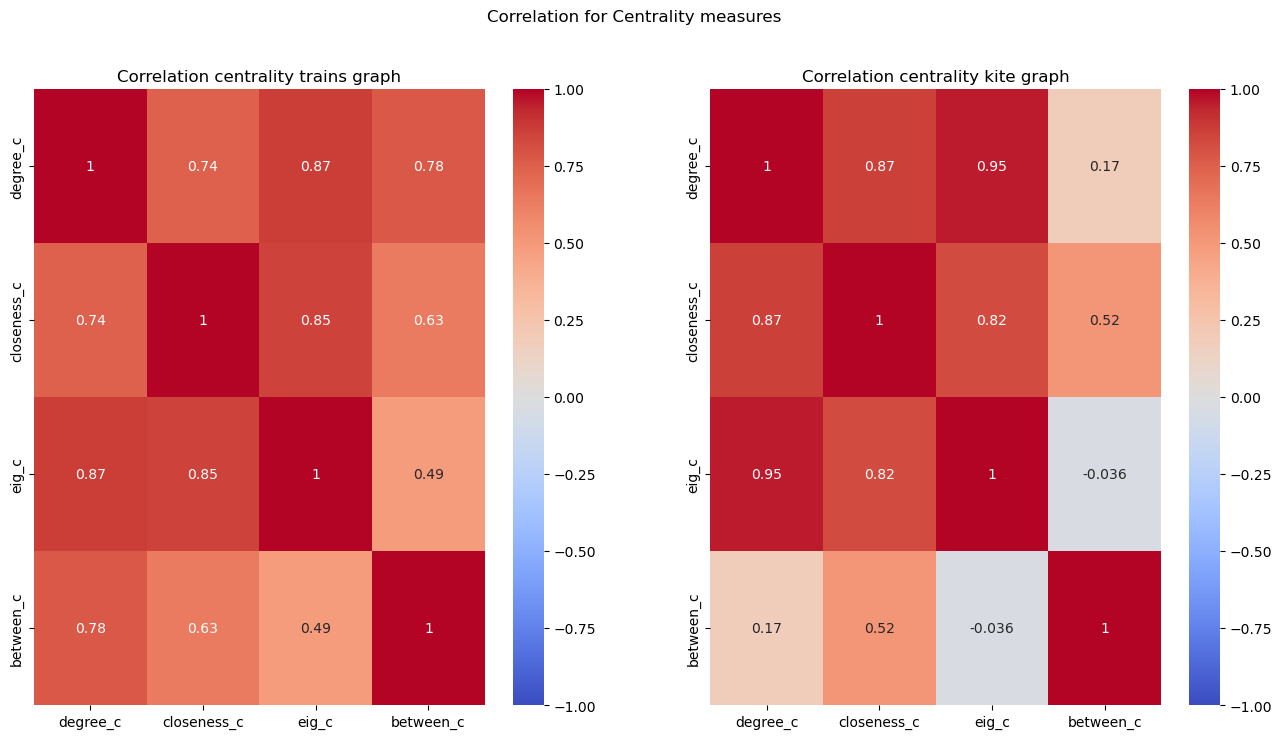

In [74]:
g_trains = load_graph_from_json("data/g_trains.json")
g_kite = nx.krackhardt_kite_graph()
results_trains = []
for i in [nx.degree_centrality, nx.closeness_centrality, nx.eigenvector_centrality, nx.betweenness_centrality]:
    res = i(g_trains)
    results_trains.append(res)

comparision_trains = pd.DataFrame({"nodes":results_trains[0].keys(), 
              "degree_c":results_trains[0].values(),
             "closeness_c":results_trains[1].values(),
              "eig_c":results_trains[2].values(),
              "between_c":results_trains[3].values()})
comparision_trains.set_index("nodes", inplace=True)

results_kite = []
for i in [nx.degree_centrality, nx.closeness_centrality, nx.eigenvector_centrality, nx.betweenness_centrality]:
    res = i(g_kite)
    results_kite.append(res)

comparision_kite = pd.DataFrame({"nodes":results_kite[0].keys(), 
              "degree_c":results_kite[0].values(),
             "closeness_c":results_kite[1].values(),
              "eig_c":results_kite[2].values(),
              "between_c":results_kite[3].values()})
comparision_kite.set_index("nodes", inplace=True)


fig, ax = plt.subplots(1,2, figsize=[16,8])
plt.suptitle("Correlation for Centrality measures")
sns.heatmap(comparision_trains.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[0])
sns.heatmap(comparision_kite.corr(), annot=True, vmin=-1, vmax=1, cmap="coolwarm", ax=ax[1]);

ax[0].set_title("Correlation centrality trains graph")
ax[1].set_title("Correlation centrality kite graph")

